## DV2599 Project
Group 8


***
Viktor Fransson

vifr22@student.bth.se

***

Tobias Gustafsson

togu22@student.bth.se
***

#### Initialize

In [62]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, f1_score, precision_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load dataset
df = pd.read_csv('playground-series-s4e11/train.csv')

# Split dataset
x = df.drop(['id', 'Name', 'Depression'], axis=1)
y = df['Depression']


x.fillna({'Profession': 'none', 'Dietary Habits': 'unknown', 'Degree' : 'none'}, inplace=True)
df['CGPA'] = pd.to_numeric(df['CGPA'], errors='coerce').fillna(0).round().astype(int)

# print(df['Dietary Habits'].isna().sum())
display(x)

,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No
1,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No
2,Male,33.0,Visakhapatnam,Student,none,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No
3,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes
4,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,Female,18.0,Ahmedabad,Working Professional,none,NaN,5.0,NaN,NaN,4.0,5-6 hours,Unhealthy,Class 12,No,2.0,4.0,Yes
140696,Female,41.0,Hyderabad,Working Professional,Content Writer,NaN,5.0,NaN,NaN,4.0,7-8 hours,Moderate,B.Tech,Yes,6.0,5.0,Yes
140697,Female,24.0,Kolkata,Working Professional,Marketing Manager,NaN,3.0,NaN,NaN,1.0,More than 8 hours,Moderate,B.Com,No,4.0,4.0,No
140698,Female,49.0,Srinagar,Working Professional,Plumber,NaN,5.0,NaN,NaN,2.0,5-6 hours,Moderate,ME,Yes,10.0,1.0,No


#### Big Data Analysisis

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


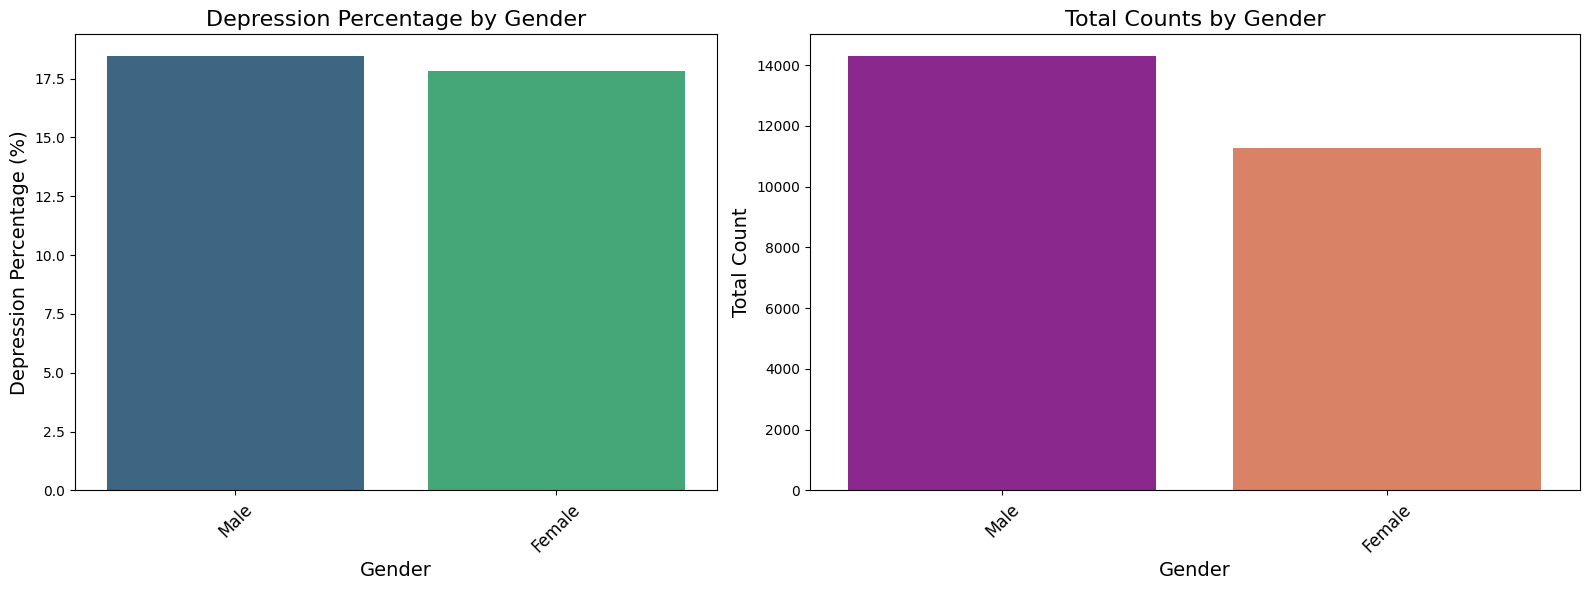

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


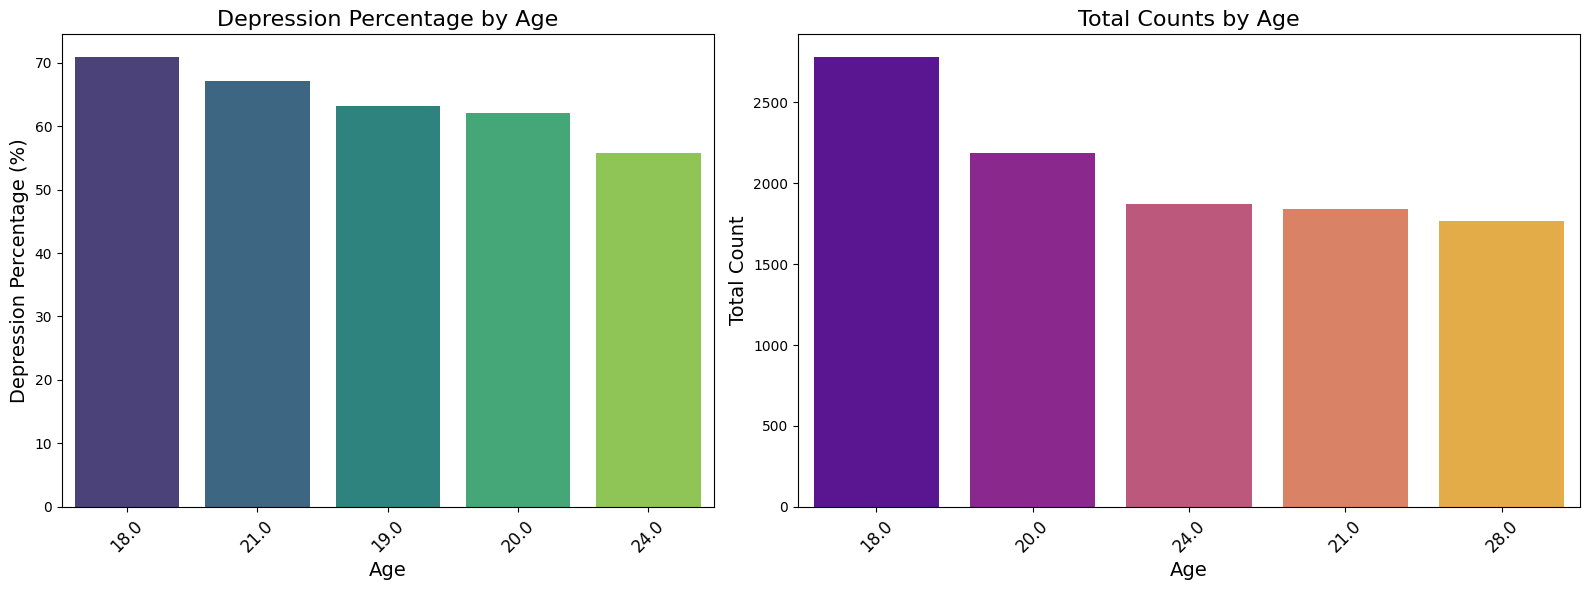

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


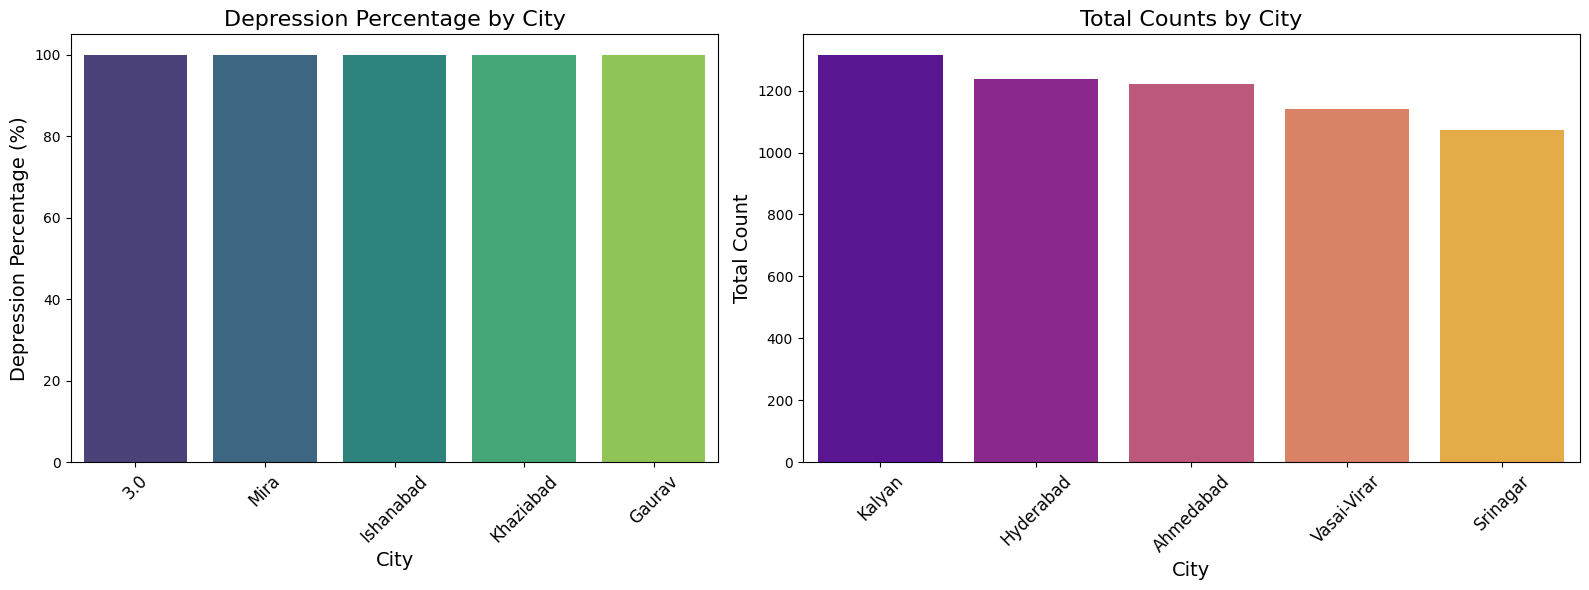

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


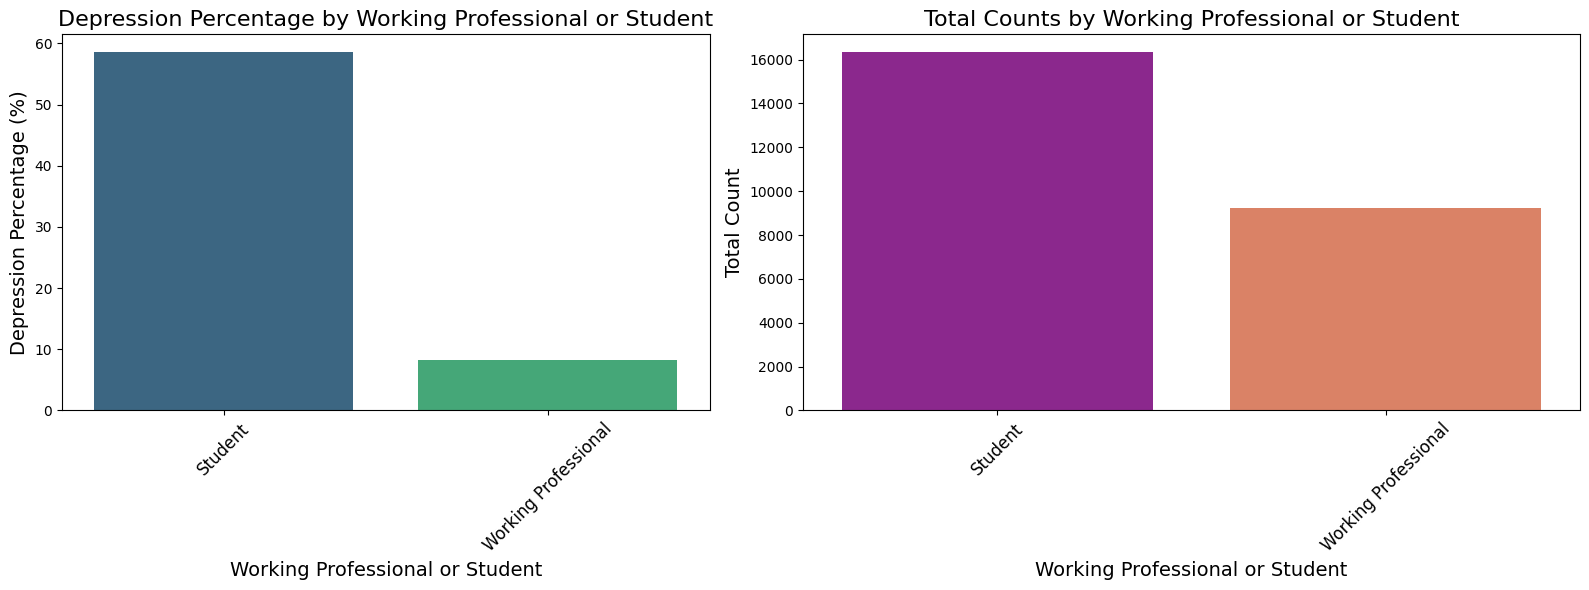

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


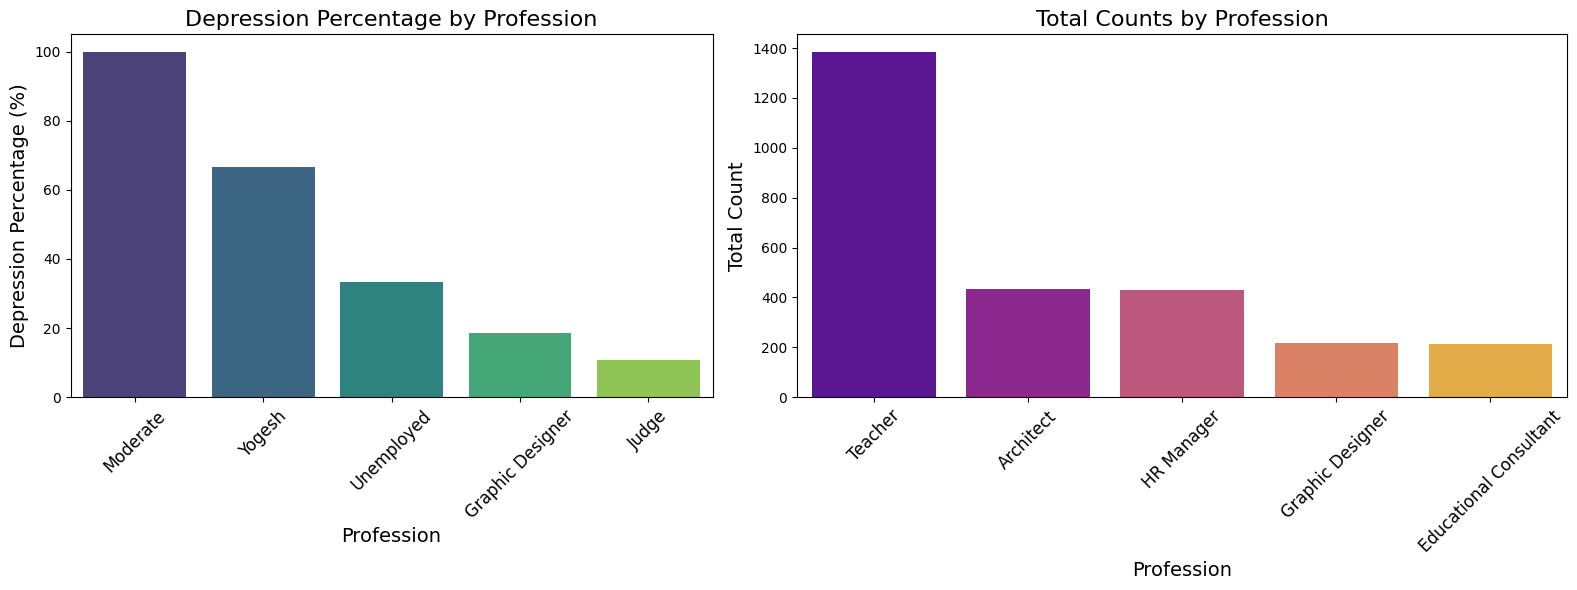

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


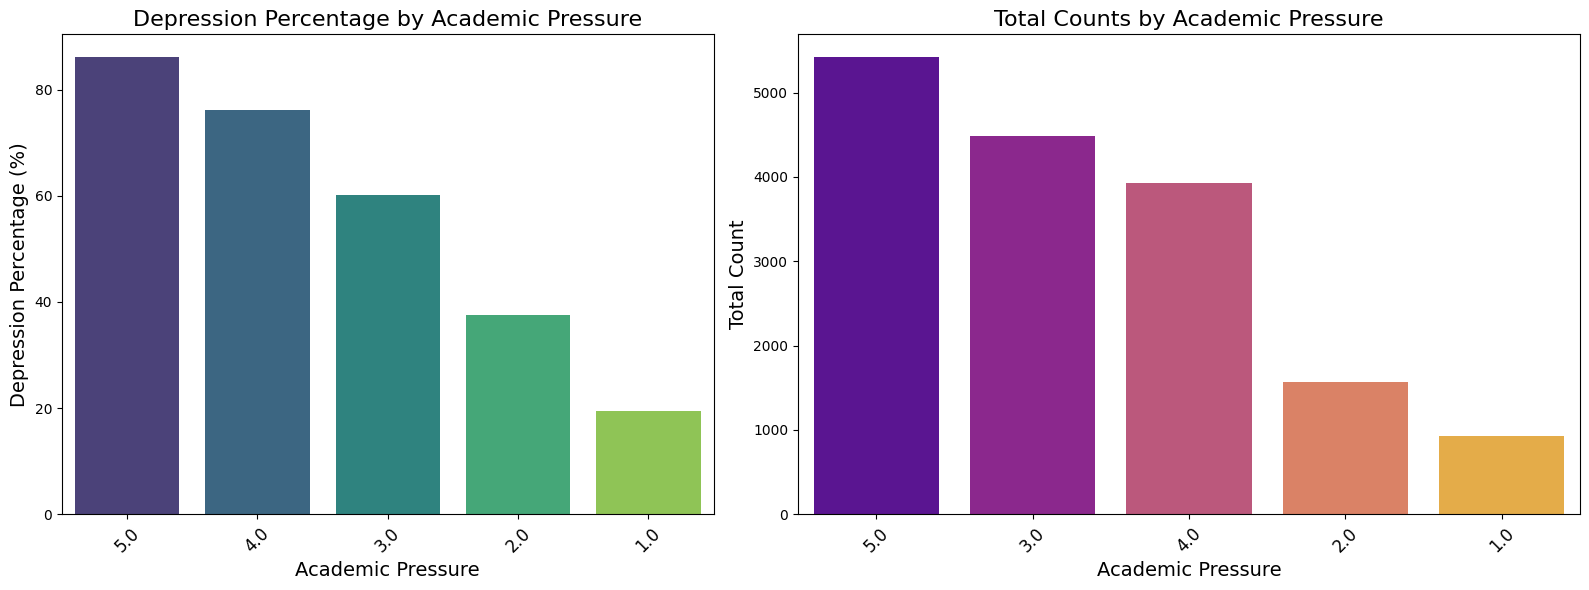

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


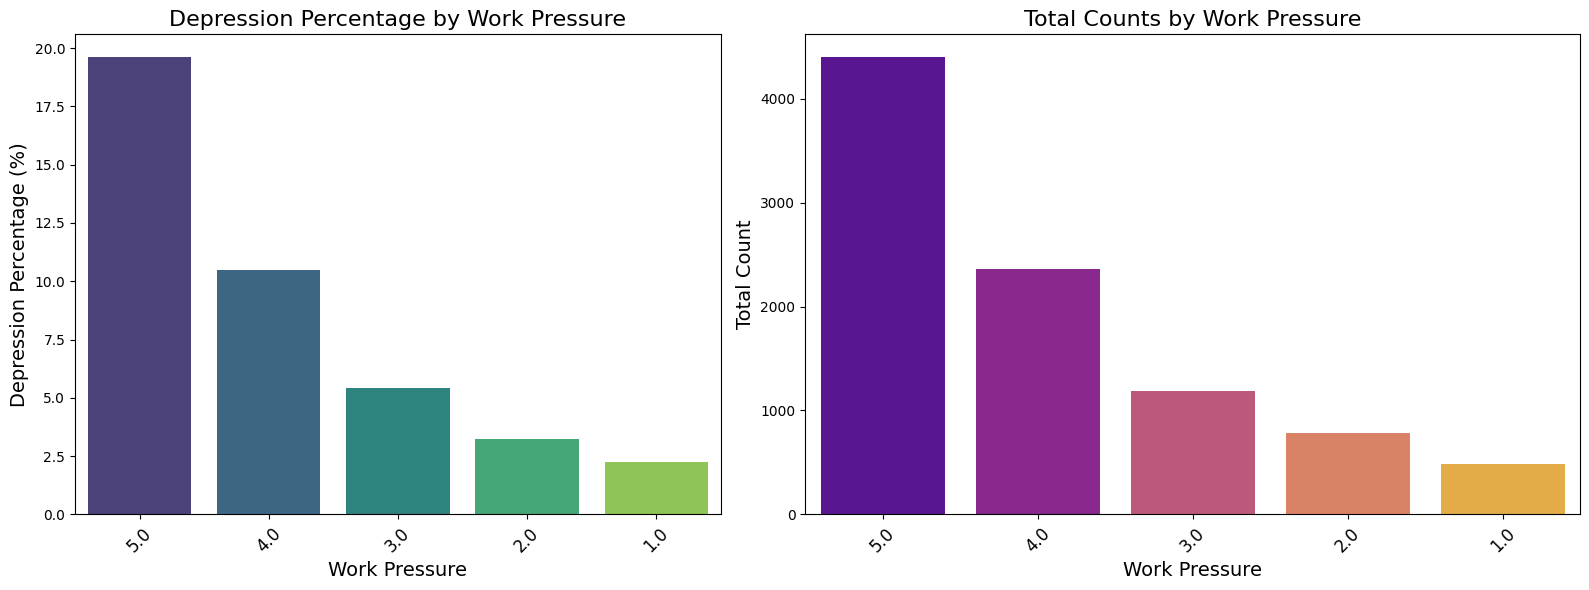

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


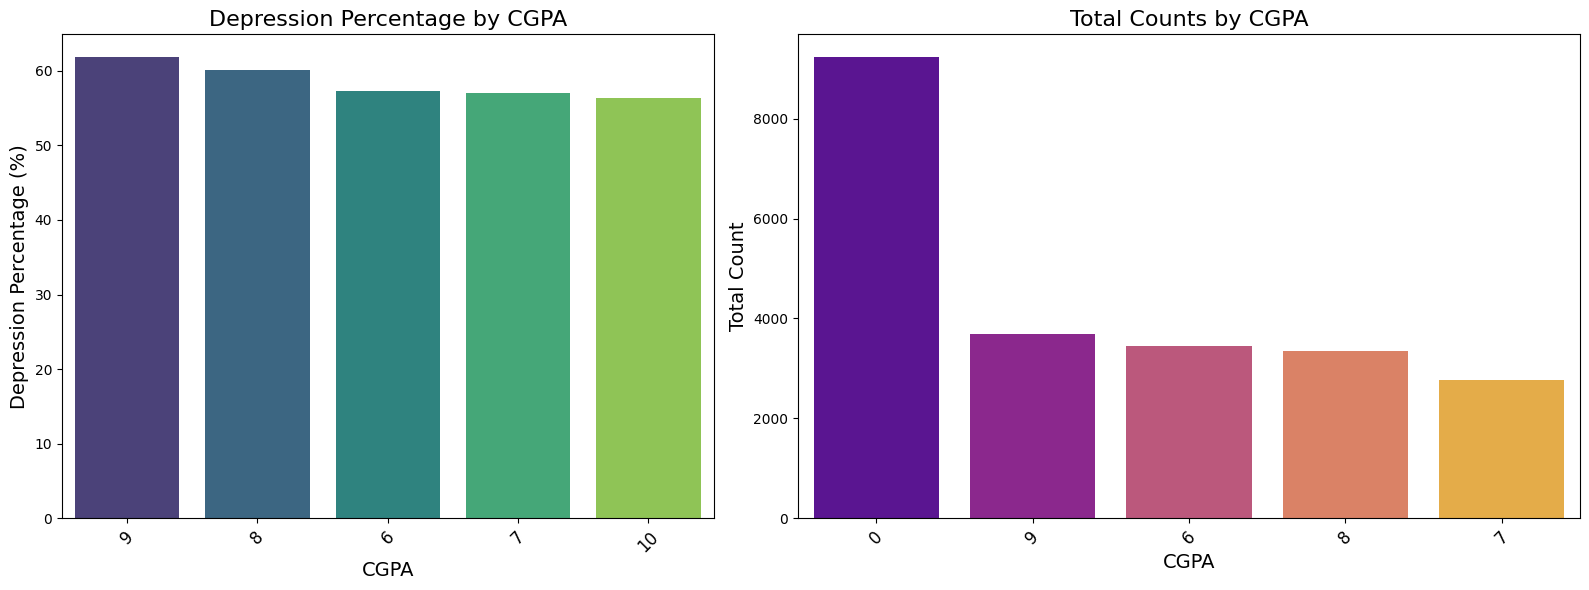

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


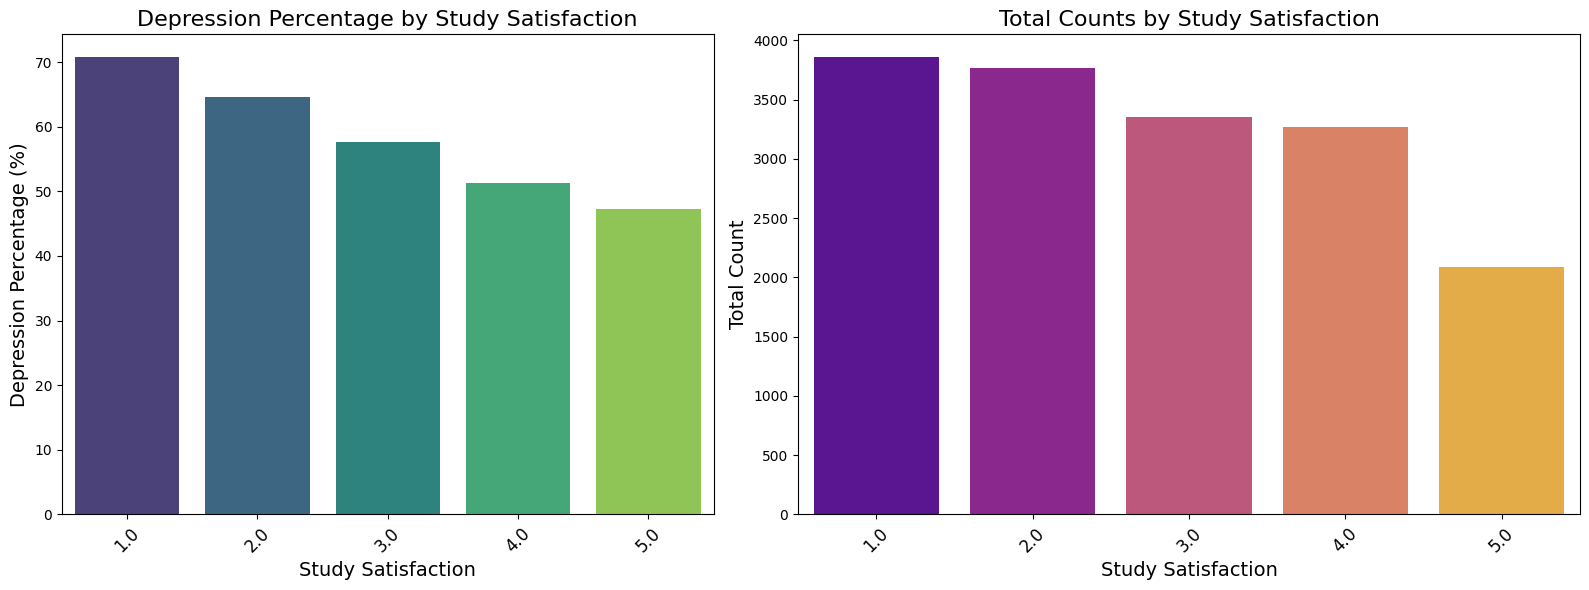

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


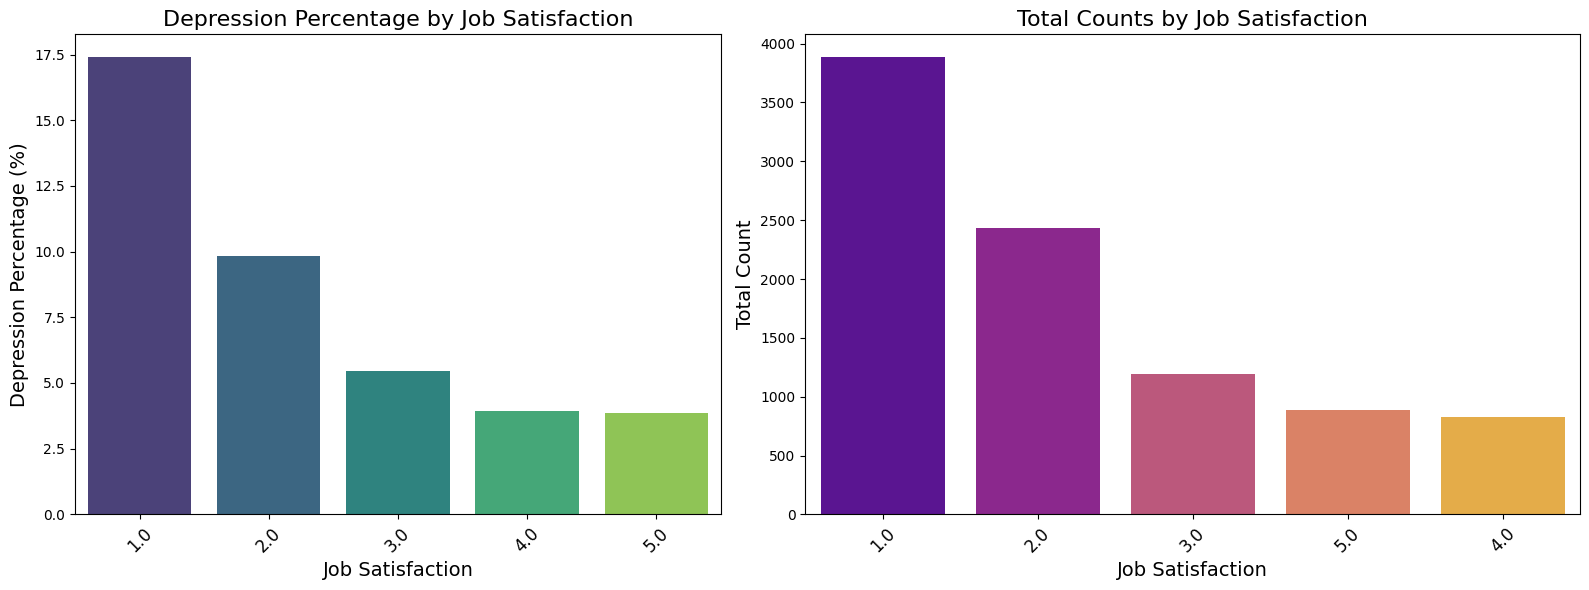

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


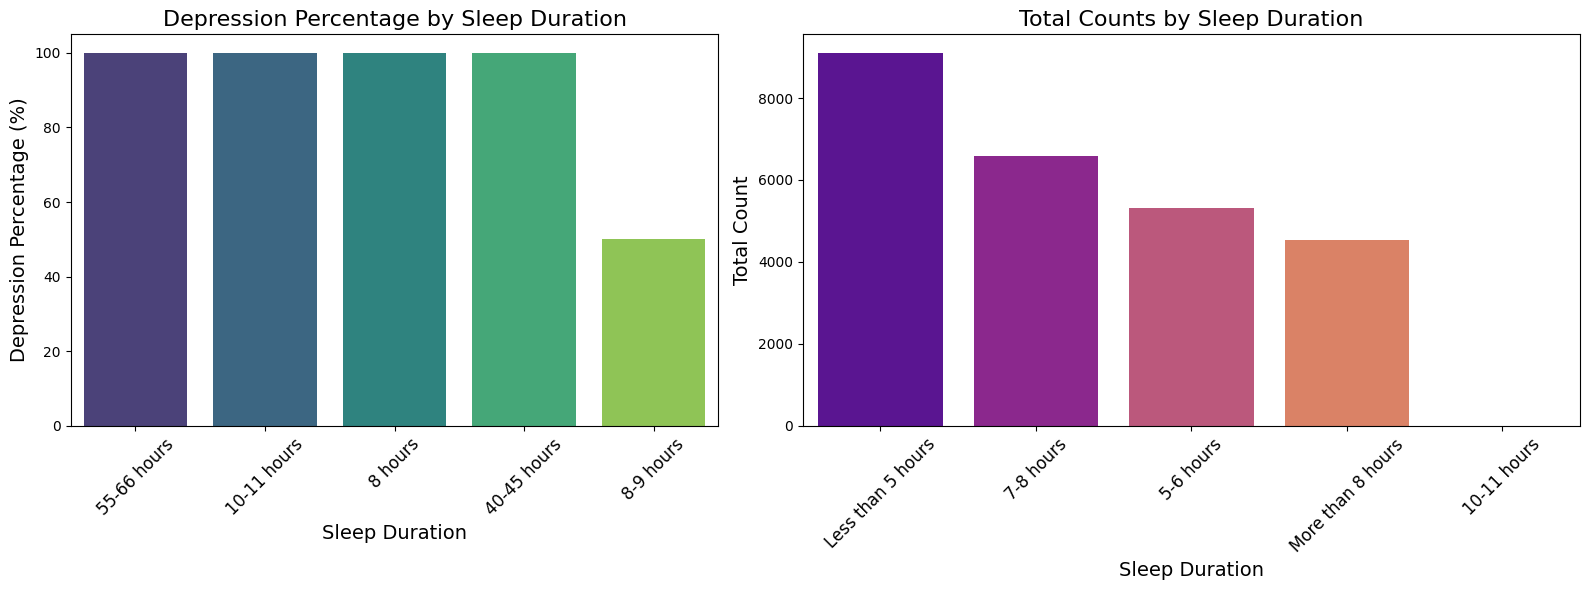

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


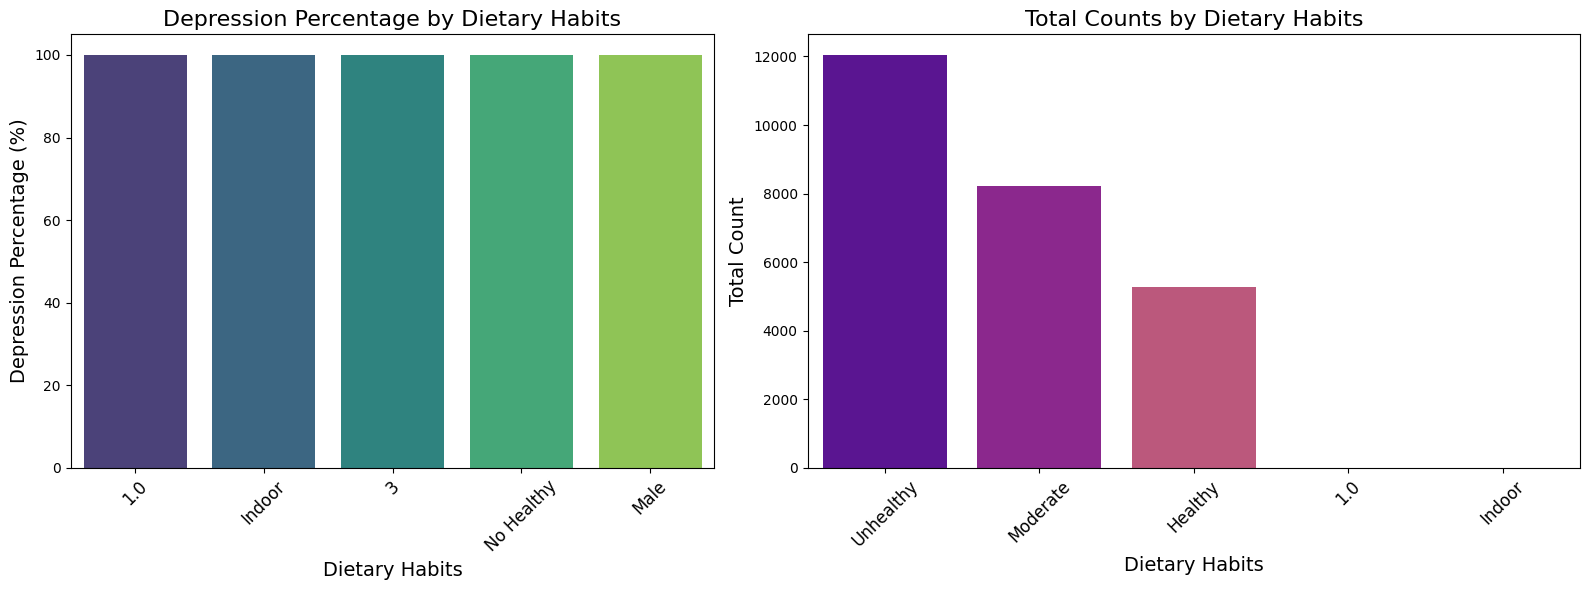

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


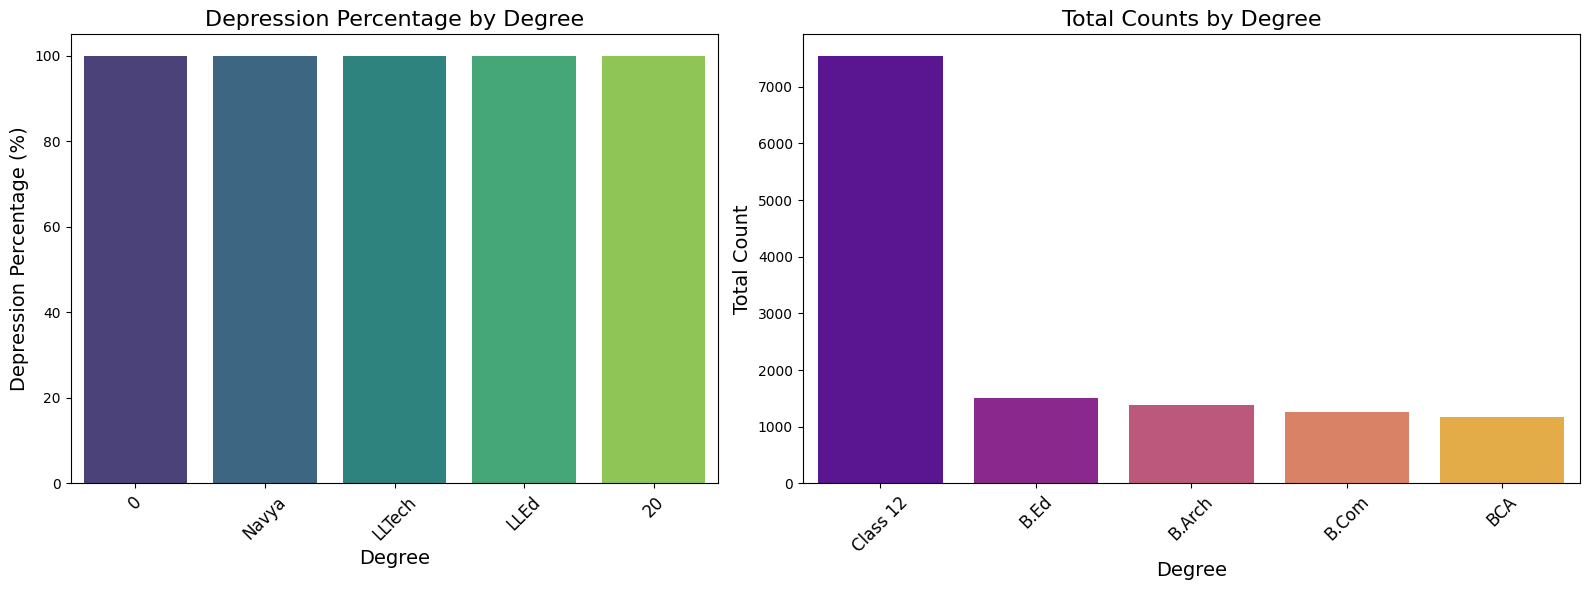

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


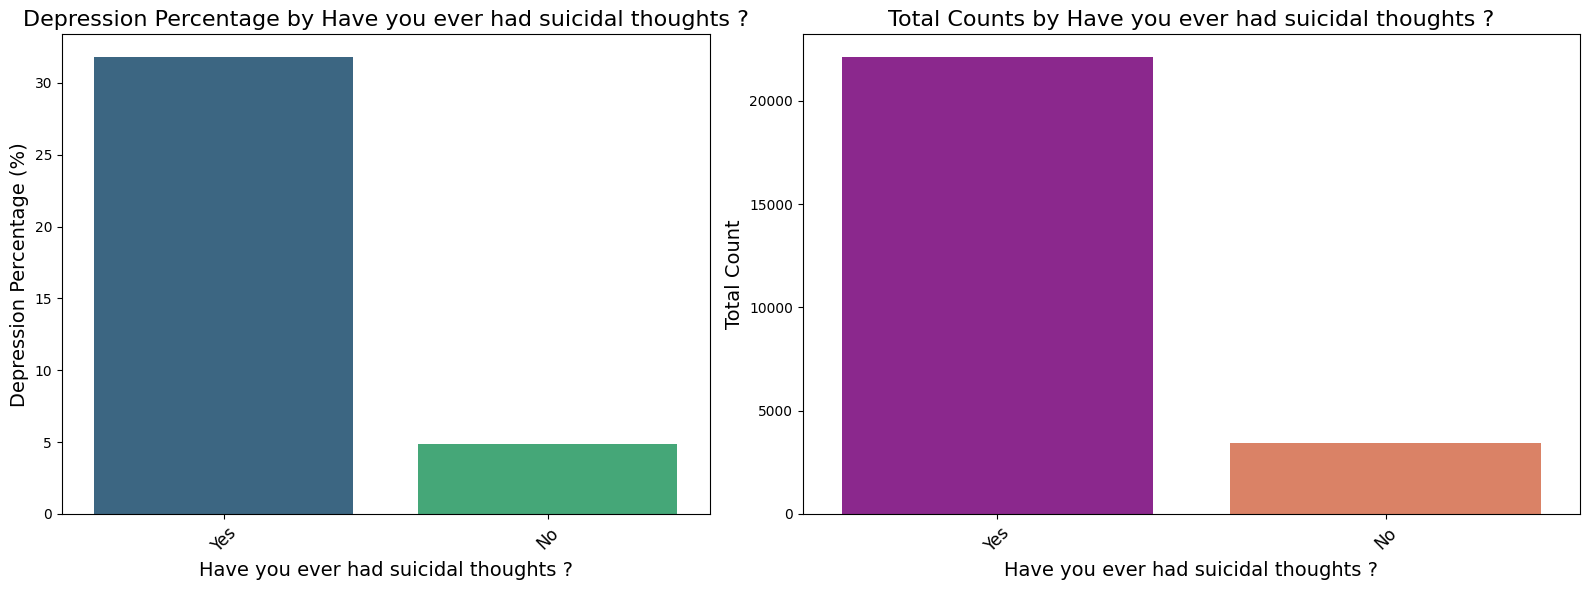

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


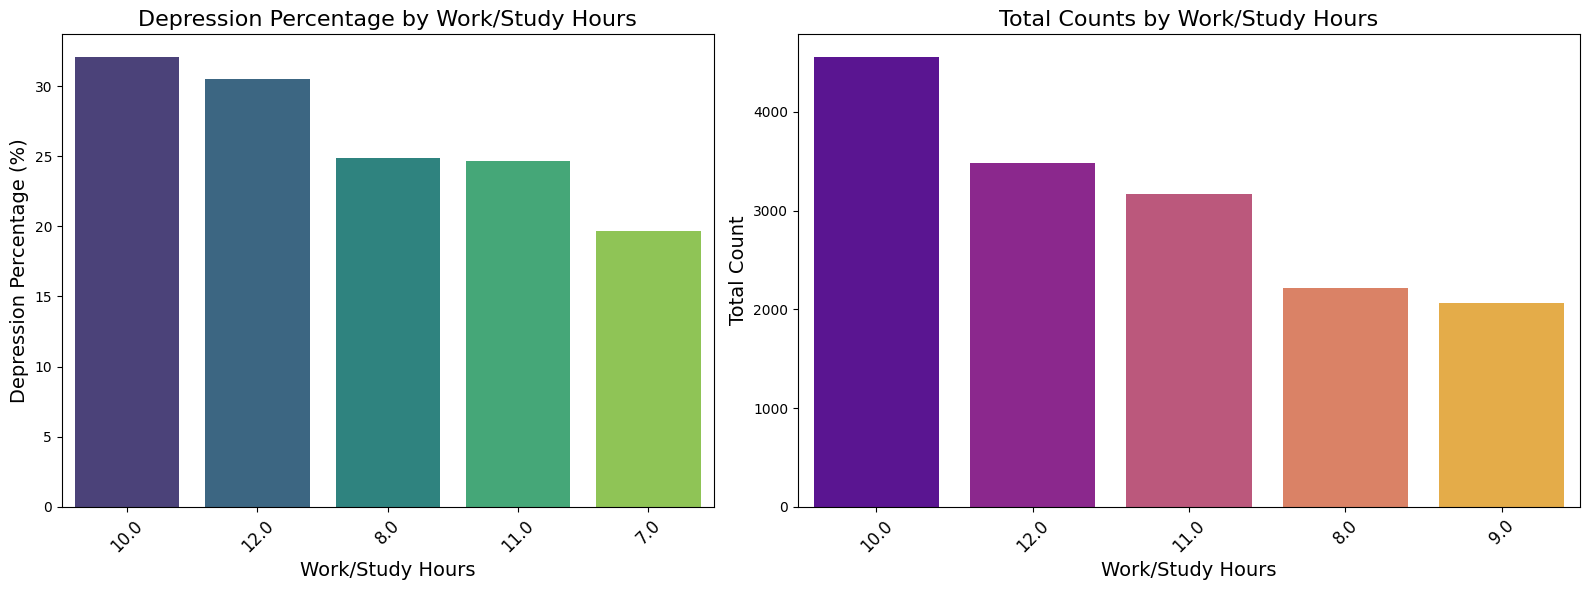

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


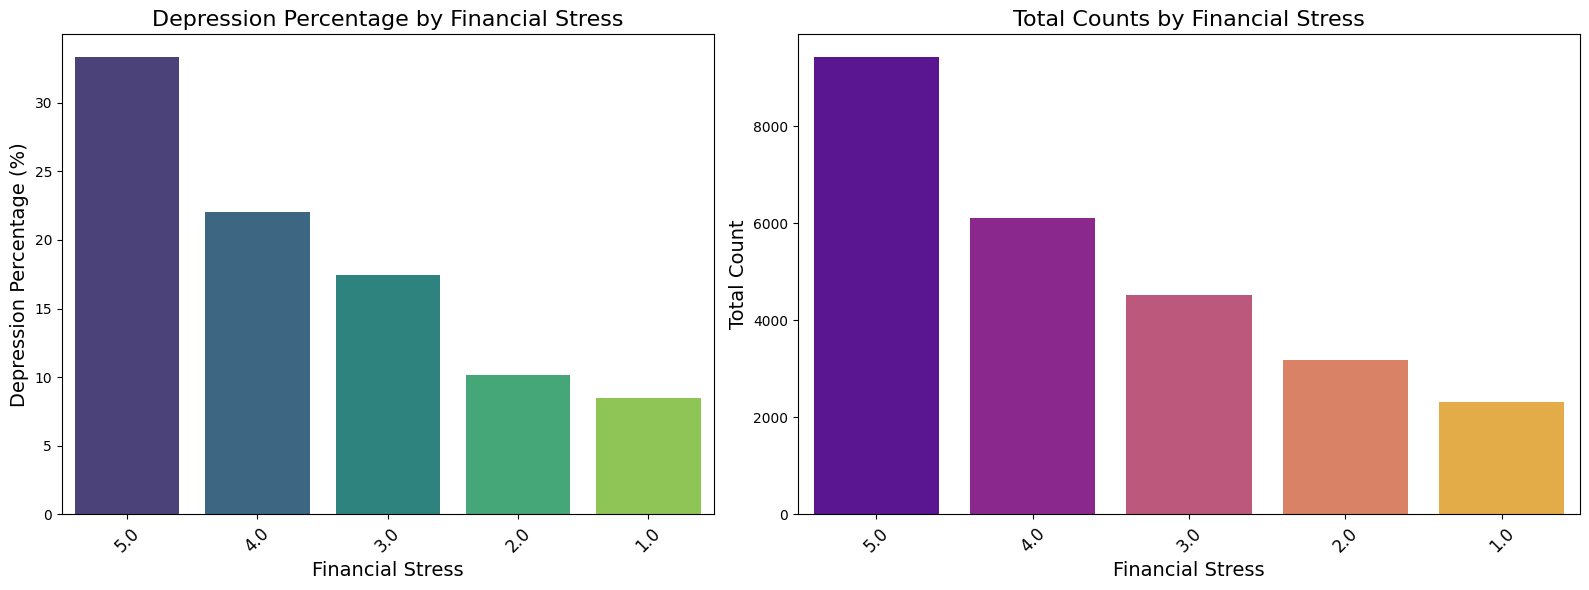

C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vikto\AppData\Local\Temp\ipykernel_22744\1407937810.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


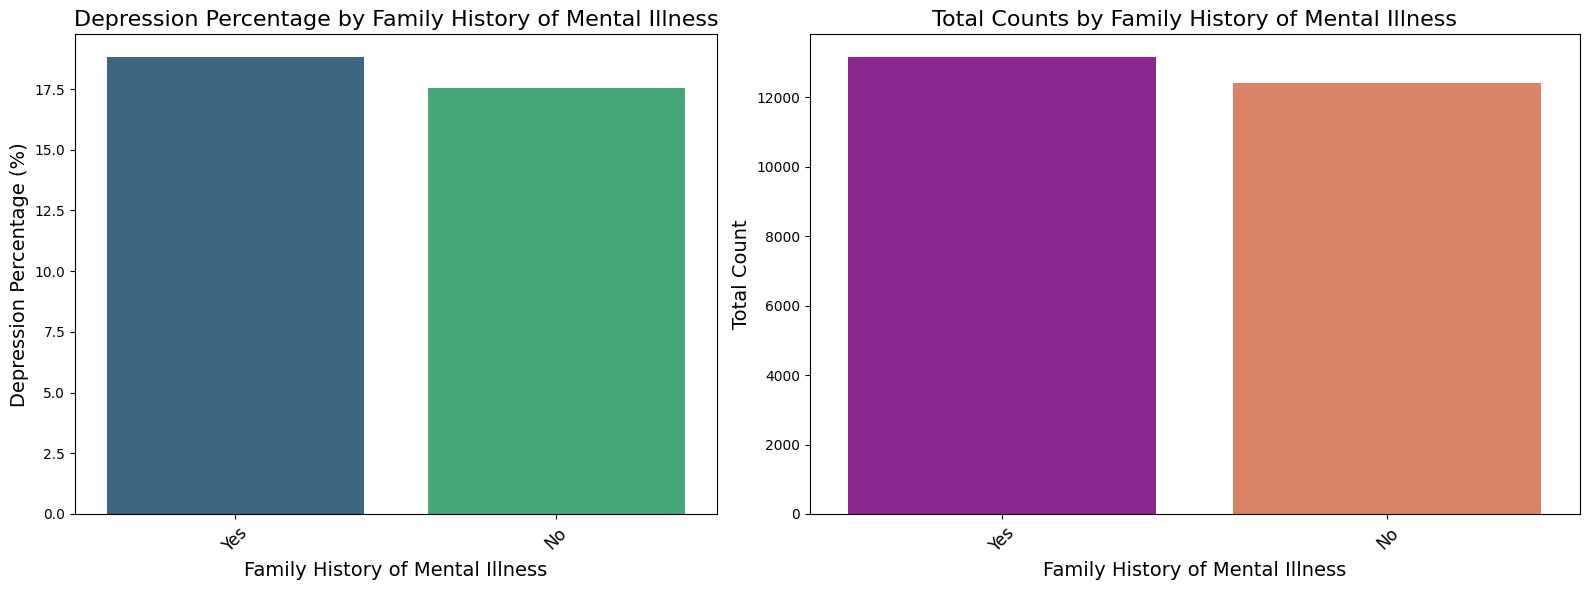

In [64]:
def plot_feature(feature):
    grouped = df.groupby(feature)['Depression']
    percentages = (grouped.sum() / grouped.count() * 100).sort_values(ascending=False).head()
    
    groups = df.groupby(col)['Depression'].sum().sort_values(ascending=False).head()
    
    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1.2]})
    
    # Bar chart for percentages
    sns.barplot(
        x=percentages.index.astype(str),  # Convert to string to ensure proper ordering
        y=percentages.values,
        palette='viridis',
        ax=axes[0]
    )
    axes[0].set_title(f"Depression Percentage by {feature}", fontsize=16)
    axes[0].set_xlabel(feature, fontsize=14)
    axes[0].set_ylabel("Depression Percentage (%)", fontsize=14)
    axes[0].tick_params(axis='x', rotation=45, labelsize=12)

    # Bar chart for counts
    sns.barplot(
        x=groups.index.astype(str),  # Convert to string to ensure proper ordering
        y=groups.values,
        palette='plasma',
        ax=axes[1]
    )
    axes[1].set_title(f"Total Counts by {feature}", fontsize=16)
    axes[1].set_xlabel(feature, fontsize=14)
    axes[1].set_ylabel("Total Count", fontsize=14)
    axes[1].tick_params(axis='x', rotation=45, labelsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()


for col in df.columns:
    if col not in ['id', 'Name', 'Depression']:
        if col == 'CGPA':
            plot_feature(col)
        else:
            plot_feature(col)


#### Boosting

In [45]:
# Prepare categorical features
cat_feats = [0, 2, 3, 4, 10, 11, 12, 13, 16]

# display(x)
dataset = Pool(data=x, label=y, cat_features=cat_feats)

cat_model = CatBoostClassifier(verbose=0)

cat_model.fit(dataset)

prediction = cat_model.predict(dataset)

accuracy = accuracy_score(y, prediction)
precision = precision_score(y, prediction)
f1 = f1_score(y, prediction)

print(accuracy, precision, f1)

0.9461336176261549 0.8653721156971076 0.8489727596994997
